# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto:

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo:

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

É possível olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que irei desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Quero descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importando Bibliotecas

In [61]:
import pandas as pd # organiza, limpa e ordena dados de forma rápida
import numpy as np # lida com números e matrizes

import seaborn as sns # visualização de gráficos mais bonitos
import matplotlib.pyplot as plt # módulo de visualização

import pathlib # acessa diretórios, copia, move e mescla arquivos

import plotly.express as px # módulo para visualização de dados de forma dinâmica

from sklearn.metrics import r2_score, mean_squared_error # métricas de regressão linear do projeto
from sklearn.linear_model import LinearRegression # Modelo de regressão
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor # Modelos regressão
from sklearn.model_selection import train_test_split # divide o dataset em dados de treino e teste

### Juntando a Base de Dados em um único arquivo

In [2]:
# diretório dos arquivos.csv
caminho = pathlib.Path('dataset')

# Defino a ordenação dos meses do ano no dicionário
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4,
         'mai':5, 'jun':6, 'jul':7, 'ago':8,
         'set':9, 'out':10, 'nov':11, 'dez':12
         }

# defino meu DataFrame principal
base_airbnb = pd.DataFrame()

# Itero pelo diretório
arquivos = caminho.iterdir()

bases_csv = []

# Determino que cada arquivo.csv seja um DataFrame, e seja incrementado à uma lista
for arquivo in arquivos:
    numero_mes = meses[arquivo.name[:3]] # obtenho o número do mês fatiando str
    ano = int(arquivo.name[-8:-4]) # fatio a str do nome do arquivo
    
    df = pd.read_csv(caminho / arquivo.name)
    
    # crio colunas mês e ano, fim referenciar a base de dados origem
    df['ano'] = ano
    df['mes'] = numero_mes
    bases_csv.append(df)

# bases_csv seja inserido no DataFrame principal
airbnb_dataset = pd.concat(bases_csv)

# visualizo o DataFrame principal (902.210 linhas x 108 colunas)
display(base_airbnb)

C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_14412\3423695446.py:23: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho / arquivo.name)
C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_14412\3423695446.py:23: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho / arquivo.name)
C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_14412\3423695446.py:23: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho / arquivo.name)
C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_14412\3423695446.py:23: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho / arquivo.name)
C:\Users\Guilherme Bibiano\AppData\Local\Temp\ipykernel_14412\3423695446.py:23: DtypeWarn

Empty DataFrame
Columns: []
Index: []

### Com o objetivo de não recarregar a base de dados diversas vezes durante a análise, atribuo à uma variável a cópia do mesmo.

In [76]:
base_airbnb = airbnb_dataset.copy()

### Excluindo colunas (não interessantes para a análise)
Também com a finalidade de evitar lentidão e Overfitting

Motivo de exclusão das colunas abaixo: não me ajudarão a correlacionar com o preço neste projeto
- Tipos de colunas a serem excluídas:
    1. Colunas com textos livres
    2. Colunas que possuem Links de qualquer tipo
    3. Colunas Redundantes
    4. Colunas que possuem todos os valores iguais ou nulos
- Para isso, criarei um arquivo em planilha com os mil primeiros registros e farei uma análise qualitativa

In [77]:
# visualizo todas as colunas existentes
print(list(base_airbnb.columns))

# Criando arquivo com os mil primeiros registros
base_airbnb.head(1000).to_csv('mil_primeiros_registros.csv')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Após análise qualitativa das colunas, levando em conta os critérios supracitados, as colunas que permaneceram são:

In [78]:
# Colunas remanescentes
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count',
           'latitude','longitude','property_type','room_type','accommodates',
           'bathrooms','bedrooms','beds', 'bed_type', 'amenities','price','security_deposit','cleaning_fee',
           'guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews',
           'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value','instant_bookable',
           'is_business_travel_ready','cancellation_policy', 'ano', 'mes'
           ]

# Filtrando o DataFrame principal para que exiba as colunas da análise qualitativa
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb) # 34 colunas permaneceram nesta primeira etapa de tratamento

host_response_time host_response_rate host_is_superhost   
0                     NaN                NaN                 f  \
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type   
0                      1.0 -22.946854 -43.182737     Apartment  \
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...   
0      Entire home/apt             4        1.0  ...  \
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin   
0                            9.0                    9.0  \
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value   
0                             9.0                    9.0                 9.0  \
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratando Valores Faltantes
- O DataFrame principal possui ~902.000 linhas.
- Colunas com +34% de valores faltantes (~306 mil) serão excluídas caso não sejam essenciais.
- O restante das colunas com poucos dados nulos comparados ao total de linhas (902 mil), as respectivas linhas serão deletadas.

In [79]:
# Defino quantas linhas o DataFrame principal possui como parâmetro de análise
base_airbnb_total_linhas = base_airbnb.shape[0]

# Itero sob as colunas e avalio os valores faltantes de acordo com o critério
for coluna in base_airbnb:
    if (base_airbnb[coluna].isnull().sum() / base_airbnb_total_linhas) > 0.34:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

# Visualizo valores null por coluna no DataFrame principal
print(base_airbnb.isnull().sum()) # 23 colunas remanescentes até o momento

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [80]:
# retiro os poucos valores nulos restantes nas colunas remanescentes
base_airbnb = base_airbnb.dropna()

# verifico o resultado
print(base_airbnb.shape) # 897.709 linhas remanescentes
print(base_airbnb.isnull().sum()) # nenhuma coluna com valor nulo

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificando Tipos de Dados em cada coluna

In [81]:
print(base_airbnb.dtypes) # tipos identificados
print('-'*60) # divisória dos prints
print(base_airbnb.iloc[0]) # primeiro valor de cada coluna

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como 'price' e 'extra_people' estão sendo reconhecidos como objeto (ao invés de float) devemos alterar o tipo de variável da coluna

In [82]:
# Coluna prices deverá ser do tipo float
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '') # retire sifrões
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '') # retire vírgulas
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False) # altere o tipo da coluna do DataFrame original para float (float32 ocupa menos memória)
# Coluna extra_people deverá ser do tipo float
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '') # retire sifrões
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '') # retire vírgulas
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False) # altere o tipo da coluna do DataFrame original para float (float32 ocupa menos memória)

# verificando os tipos de cada coluna após tratamento
print(base_airbnb.dtypes) 

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratando Outliers
- Verifico a correlação entre features através do mapa de calor do Seaborn com o objetivo de retirar correlações altas que não implicam causalidade.

<Axes: >

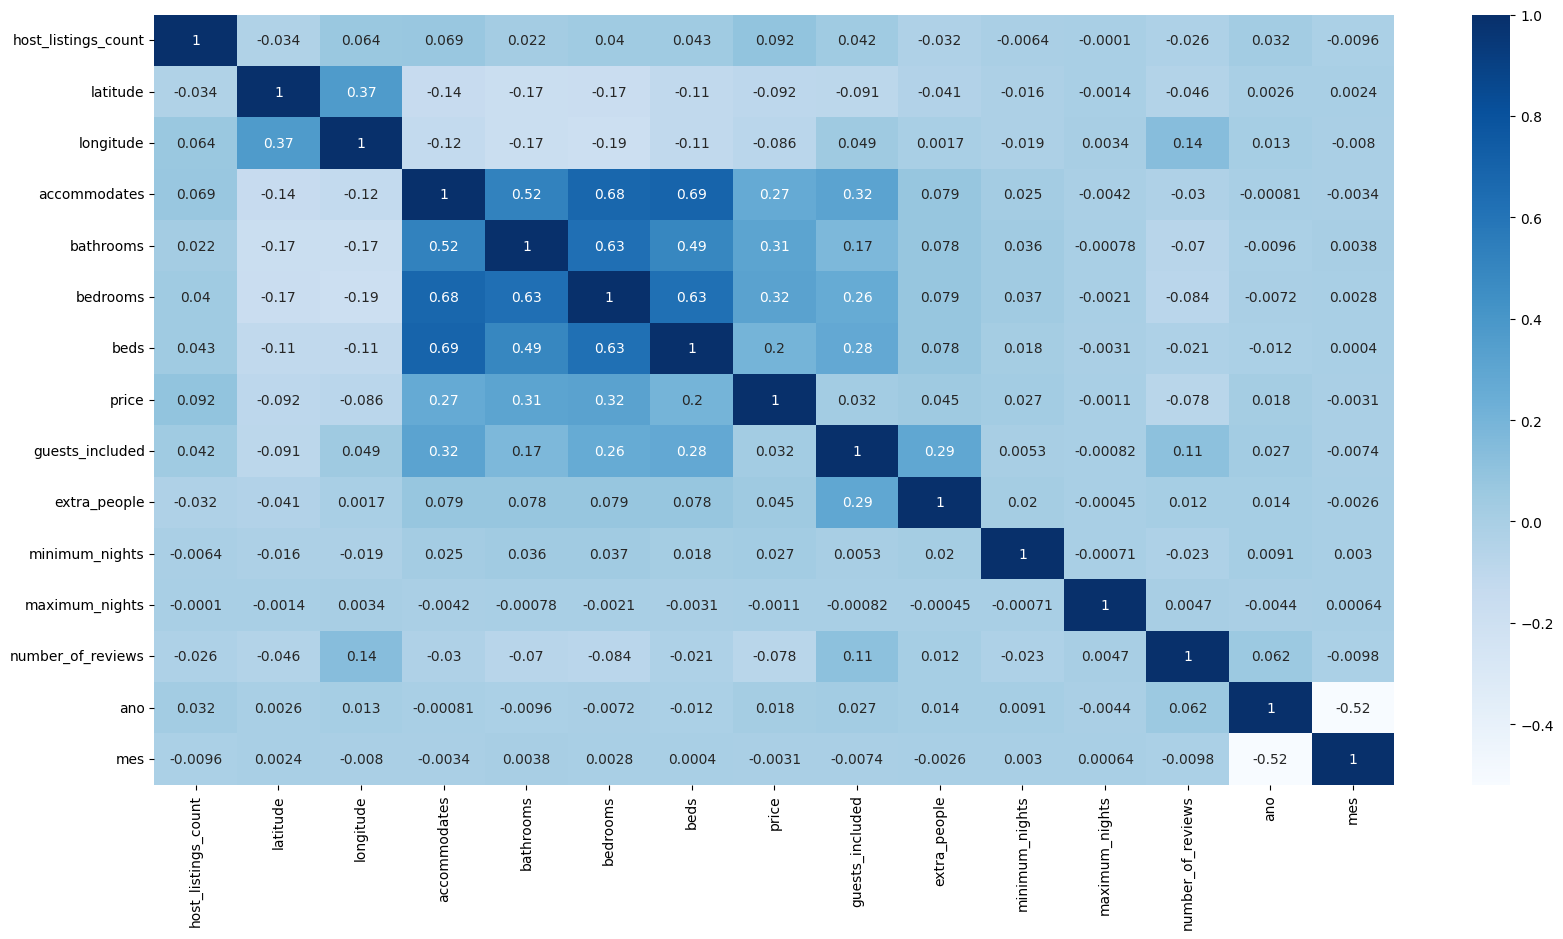

In [83]:
plt.figure(figsize=(20,10)) # altero o tamanho da imagem
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Blues') # crio o mapa de calor

### Defino funções para facilitar a análise:
- limites (define os limites do Box Plot de uma coluna específica)
- clear_outliers (exclui os outliers de uma coluna qualquer)
- box_plot (cria dois gráficos Box Plot, um sendo o panorama geral com outliers e outro dentro dos limites)
- histogram (retorna um histograma com base em uma coluna)
- bar_plot (exibe um gráfico de barras da coluna inserida como parâmetro)

In [84]:
# Criando a função para mensurar possíveis outliers através da amplitude interquartil
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - (1.5 * iqr)
    limite_superior = q3 + (1.5 * iqr)
    
    return (limite_inferior,limite_superior)

# Function que exclui outliers
def clear_outliers(df, coluna):
    # guardo a quantidade de linhas
    qtde_linhas = df.shape[0]
    
    # armazeno os limites sup/inf
    lim_inf, lim_sup = limites(df[coluna])

    # filtro com valores dentro dos limites
    df = df.loc[(df[coluna] >= lim_inf) & (df[coluna] <= lim_sup), :]
    
    # retorno o DataFrame e quantas linhas foram retiradas
    linhas_retiradas = qtde_linhas - df.shape[0]
    percent_linhas_retiradas = (1 - (df.shape[0] / qtde_linhas)) * 100
    relatorio_linhas = f'{linhas_retiradas} linhas retiradas, aproximadamente: {percent_linhas_retiradas:.2f}%'
    return df, relatorio_linhas

In [85]:
# function que exibe dois boxplots
def box_plot(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

# function que exibe um histograma
def histogram(coluna):
    plt.figure(figsize=(15,5))
    plt.xlim(limites(coluna))
    sns.histplot(coluna, element='bars')

# function que exibe um gráfico de barras
def bar_plot(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Análise da coluna Price
- Por estar construindo um modelo para imóveis comuns, os valores acima do limite superior serão apenas apartamentos de luxo, cujos valores excluirei.

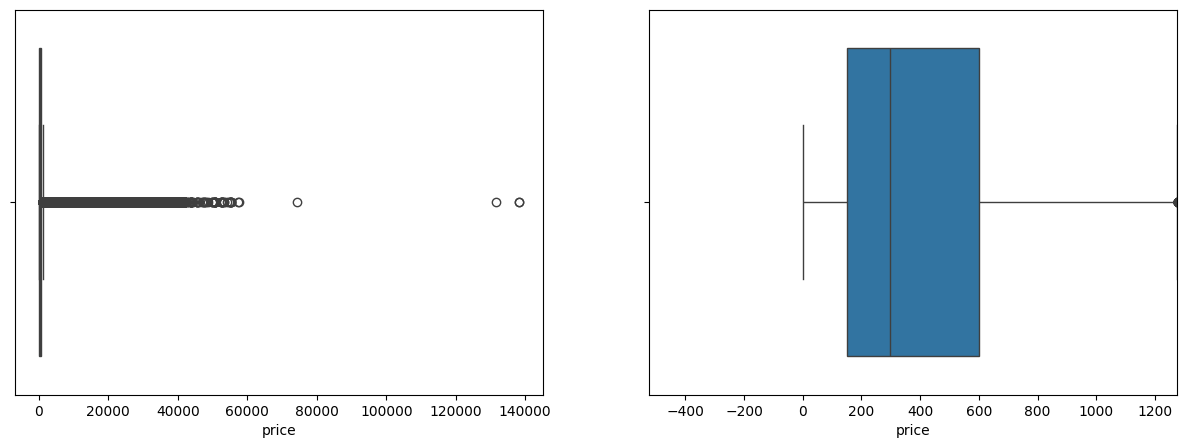

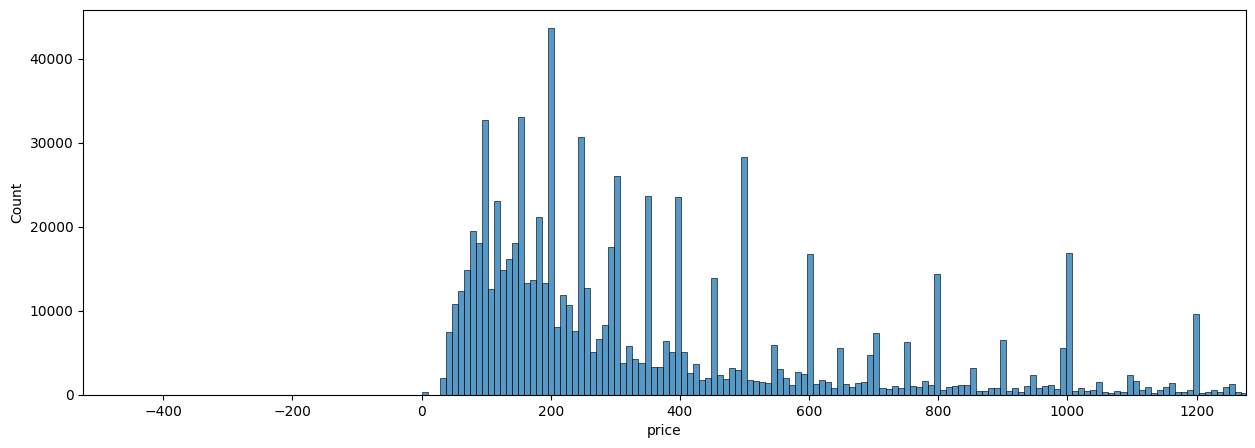

In [86]:
box_plot(base_airbnb['price'])
histogram(base_airbnb['price'])

In [87]:
# Removendo outliers da coluna Price
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'price')
print(linhas_removidas)

87282 linhas retiradas, aproximadamente: 9.72%


### Análise da coluna Extra_People

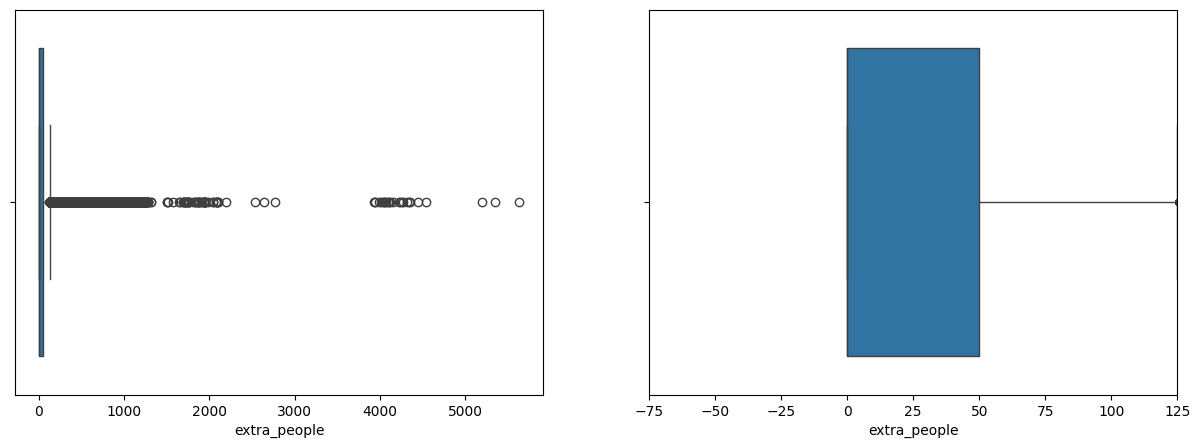

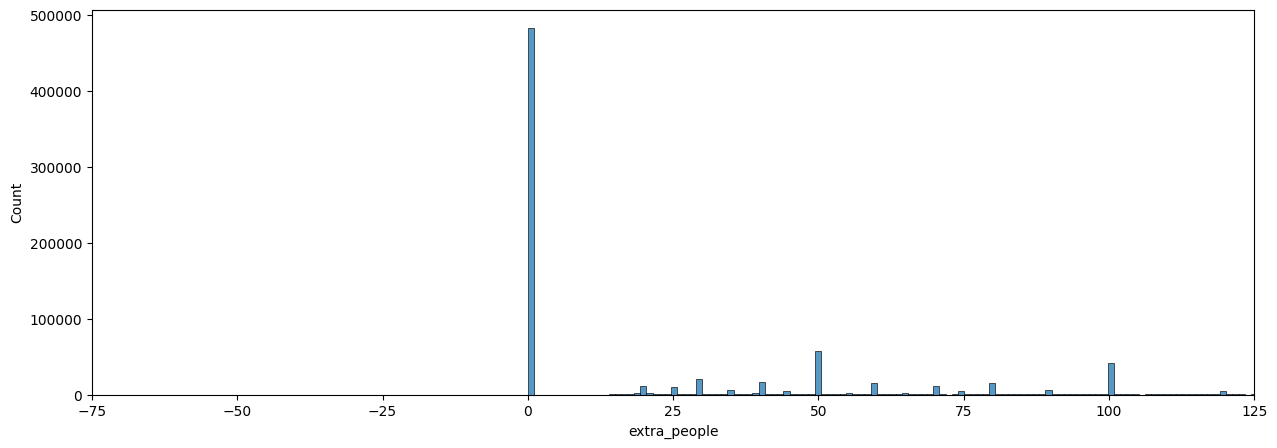

In [88]:
box_plot(base_airbnb['extra_people'])
histogram(base_airbnb['extra_people'])

In [89]:
# Removendo outliers da coluna Extra_People
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'extra_people')
print(linhas_removidas)

59194 linhas retiradas, aproximadamente: 7.30%


### Analisando valores contínuos discretos:
1. host_listings_count         
2. accommodates                  
3. bathrooms                   
4. bedrooms                    
5. beds                        
6. guests_included
7. minimum_nights                
8. maximum_nights                
9. number_of_reviews             

### 1. host_listings_count

### Excluo outliers de host_listing_counts
- pelo fato de não abordar o público alvo do projeto (pessoas comuns anunciando ou alugando airbnb).

In [90]:
# Removendo outliers da coluna host_listings_count
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'host_listings_count')
print(linhas_removidas)

97723 linhas retiradas, aproximadamente: 13.01%


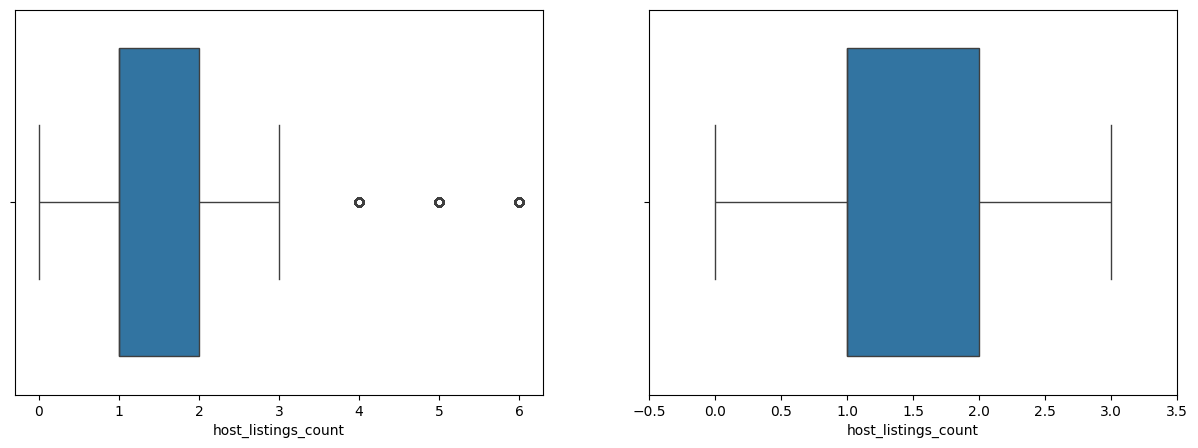

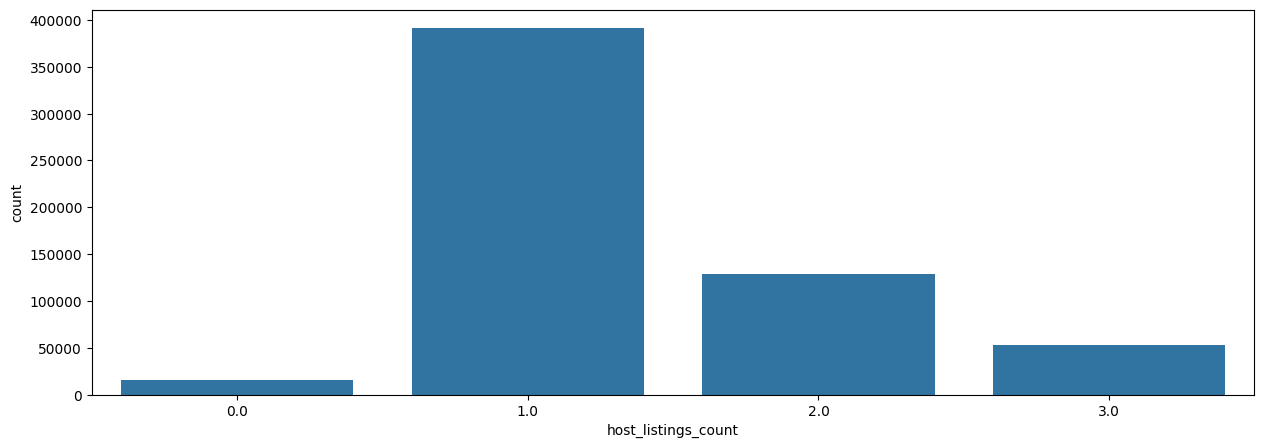

In [91]:
box_plot(base_airbnb['host_listings_count'])
bar_plot(base_airbnb['host_listings_count'])

### 2. accommodates

- são poucos valores a serem excluídos mas optei por retirá-los mesmo assim.

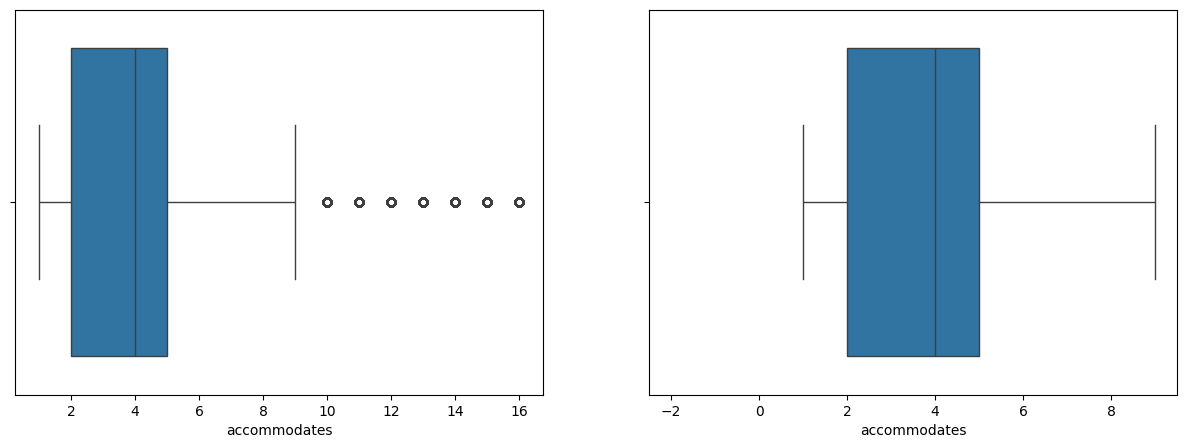

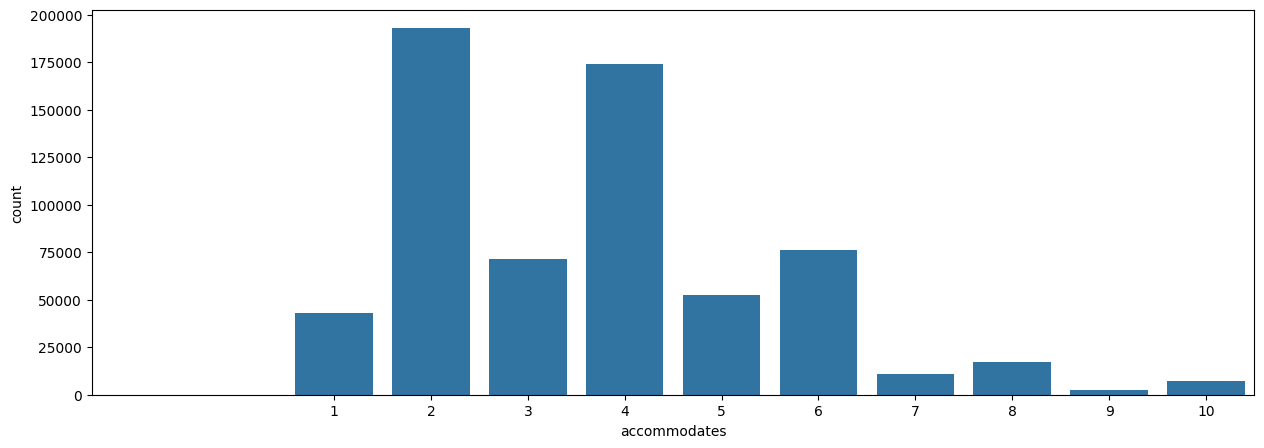

In [92]:
box_plot(base_airbnb['accommodates'])
bar_plot(base_airbnb['accommodates'])

In [93]:
# Removendo outliers da coluna accommodates
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'accommodates')
print(linhas_removidas)

13146 linhas retiradas, aproximadamente: 2.01%


### 3. bathrooms
- removo os poucos outliers existentes.

<Axes: xlabel='bathrooms', ylabel='count'>

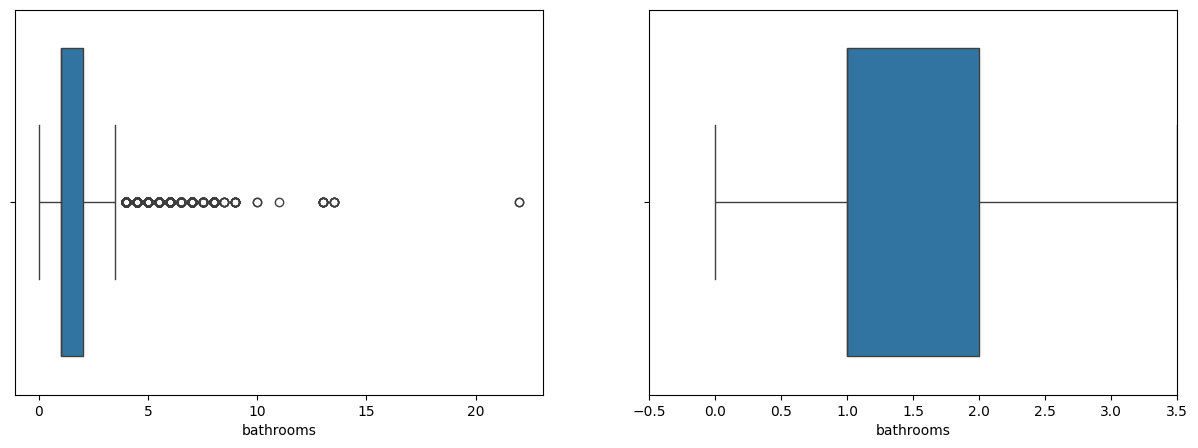

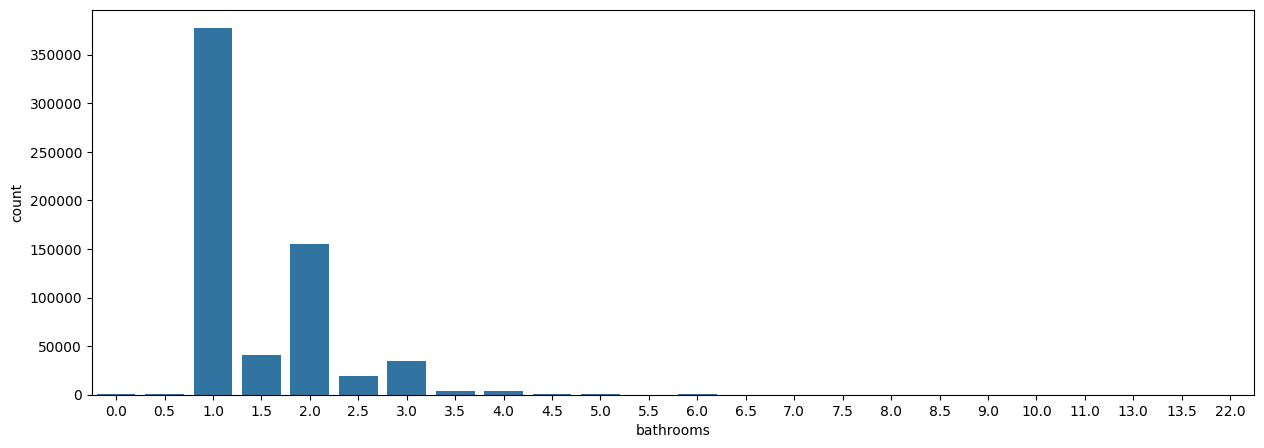

In [94]:
box_plot(base_airbnb['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [95]:
# Removendo outliers da coluna bathrooms
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'bathrooms')
print(linhas_removidas)

6894 linhas retiradas, aproximadamente: 1.08%


### 4. bedrooms

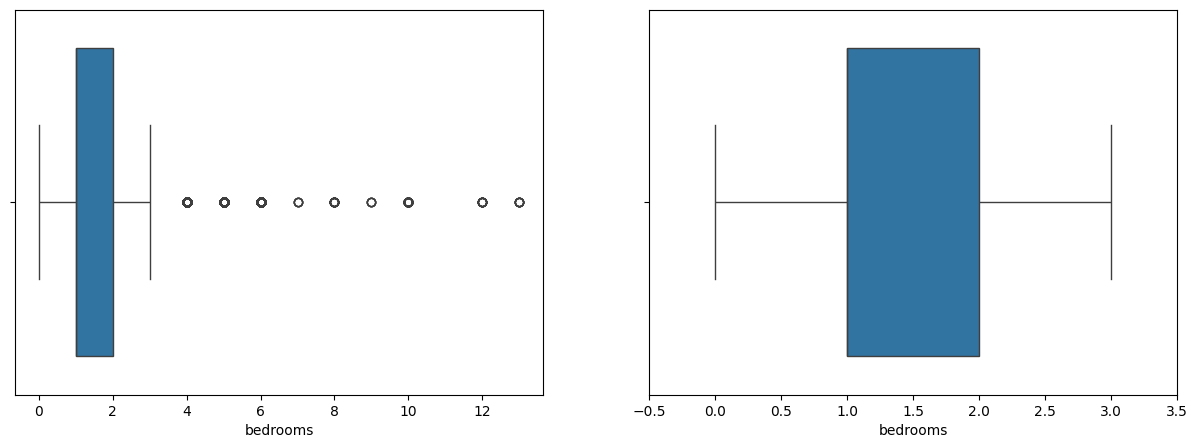

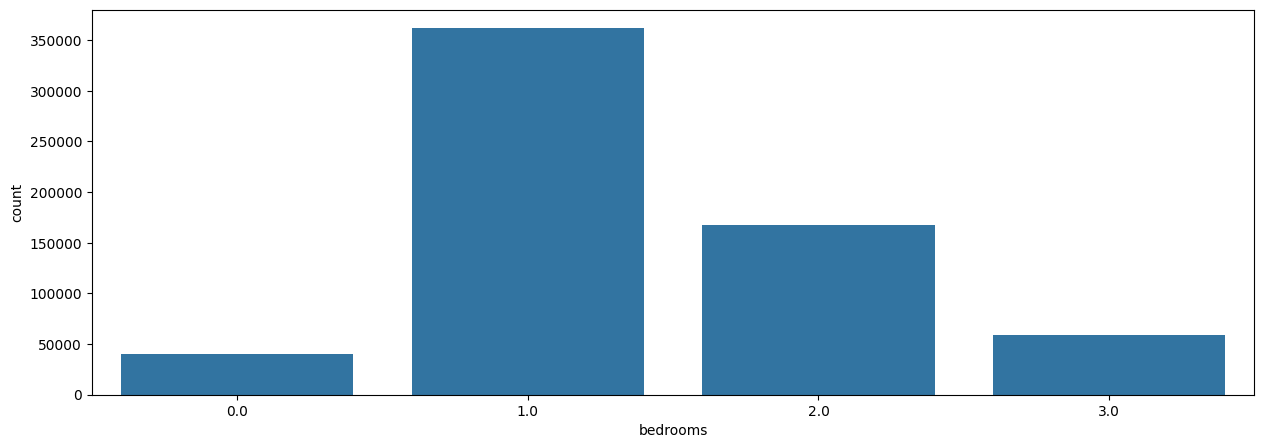

In [96]:
box_plot(base_airbnb['bedrooms'])
bar_plot(base_airbnb['bedrooms'])

In [97]:
# Removendo outliers da coluna bedrooms
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'bedrooms')
print(linhas_removidas)

5482 linhas retiradas, aproximadamente: 0.87%


### 5. beds

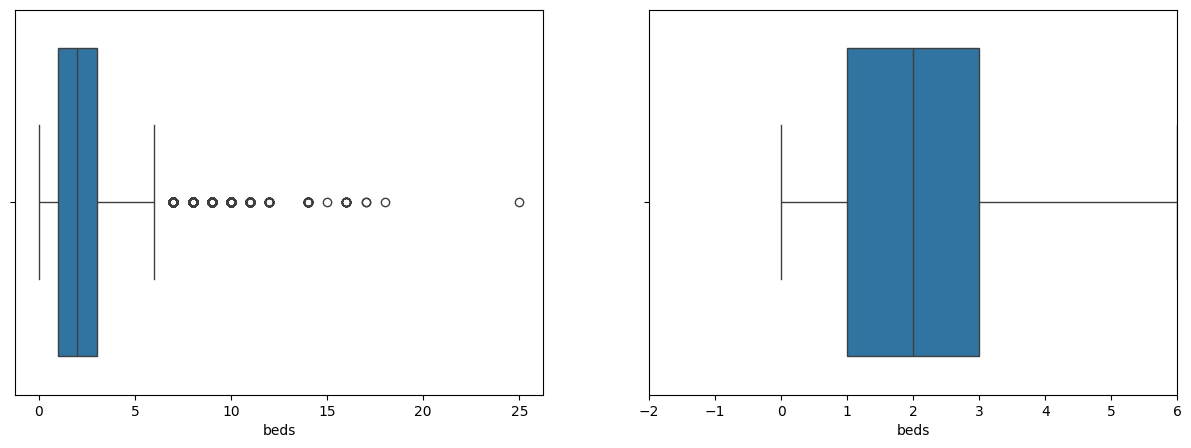

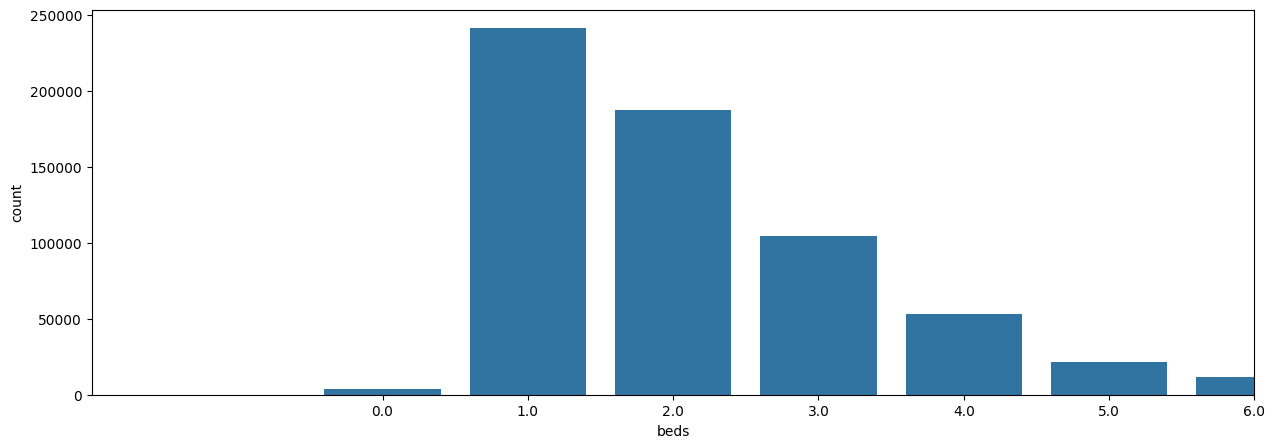

In [98]:
box_plot(base_airbnb['beds'])
bar_plot(base_airbnb['beds'])

In [99]:
# Removendo outliers da coluna beds
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'beds')
print(linhas_removidas)

5622 linhas retiradas, aproximadamente: 0.90%


### 6. guests_included
- esta coluna aparentemente possui um problema de valores ausentes, não removerei os outliers, mas sim a coluna toda para evitar que o modelo considere uma feature não essencial para definição do preço

<Axes: xlabel='guests_included', ylabel='count'>

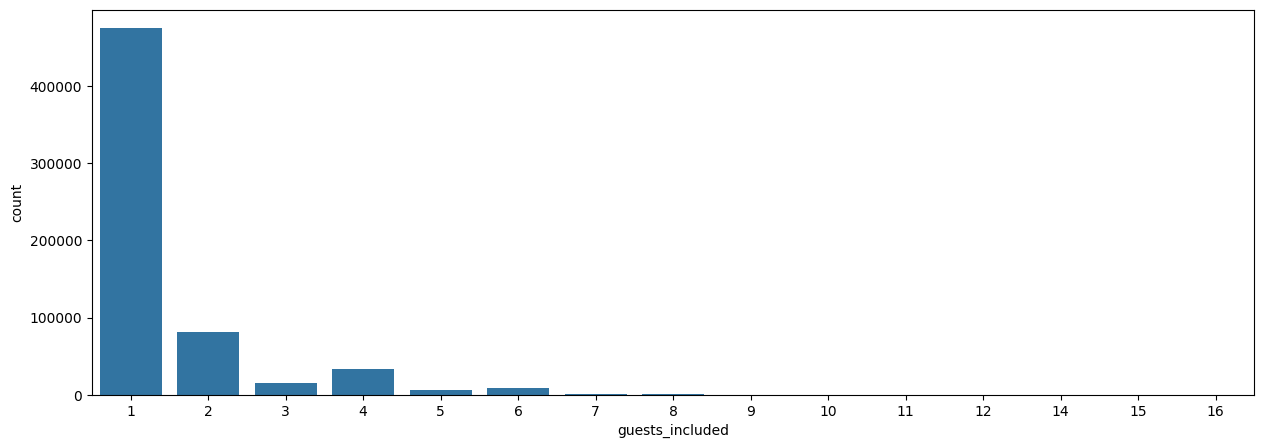

In [100]:
# Não funcionam neste caso as funções comentadas abaixo:
# box_plot(base_airbnb['guests_included'])
# bar_plot(base_airbnb['guests_included'])

plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

In [101]:
# Removendo a coluna guests_included
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### 7. minimum_nights
- A maioria das diárias se encontram dentro do Box Plot, sendo assim, retiro os outliers.

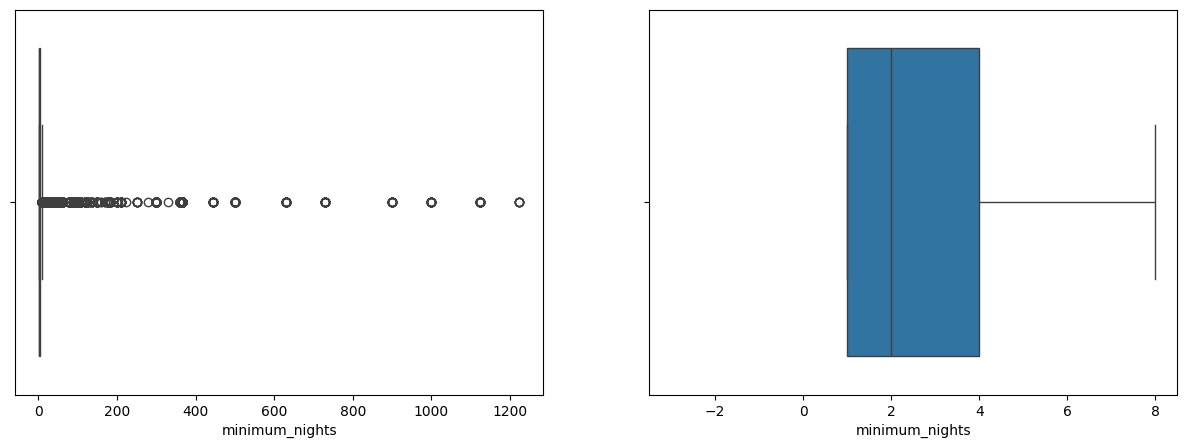

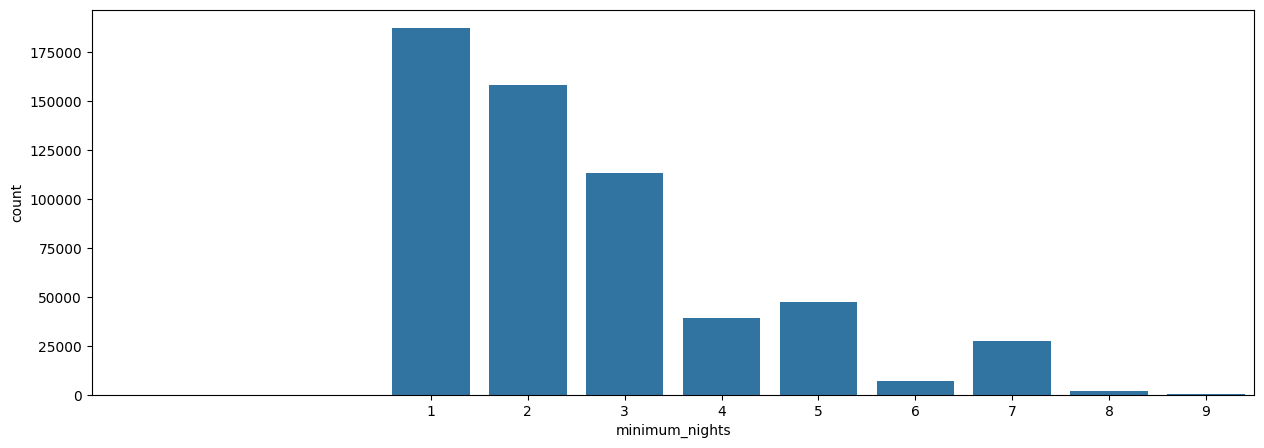

In [102]:
box_plot(base_airbnb['minimum_nights'])
bar_plot(base_airbnb['minimum_nights'])

In [103]:
# Removendo outliers da coluna minimum_nights
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'minimum_nights')
print(linhas_removidas)

40383 linhas retiradas, aproximadamente: 6.49%


### 8. maximum_nights
- os valores variam entre 0 e 2 mil diárias e os limites não estão bem definidos pelo Box Plot, não parece uma boa métrica para a análise. Esta coluna será excluida.

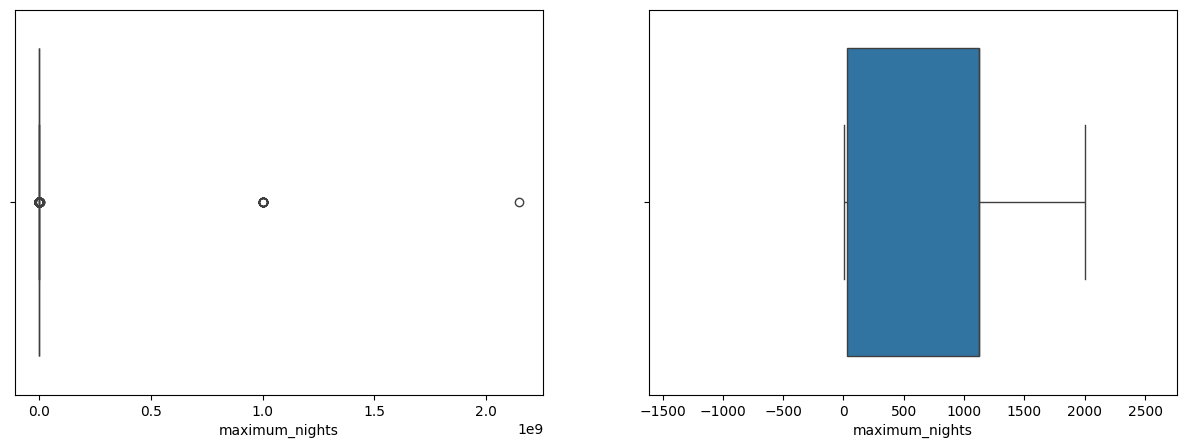

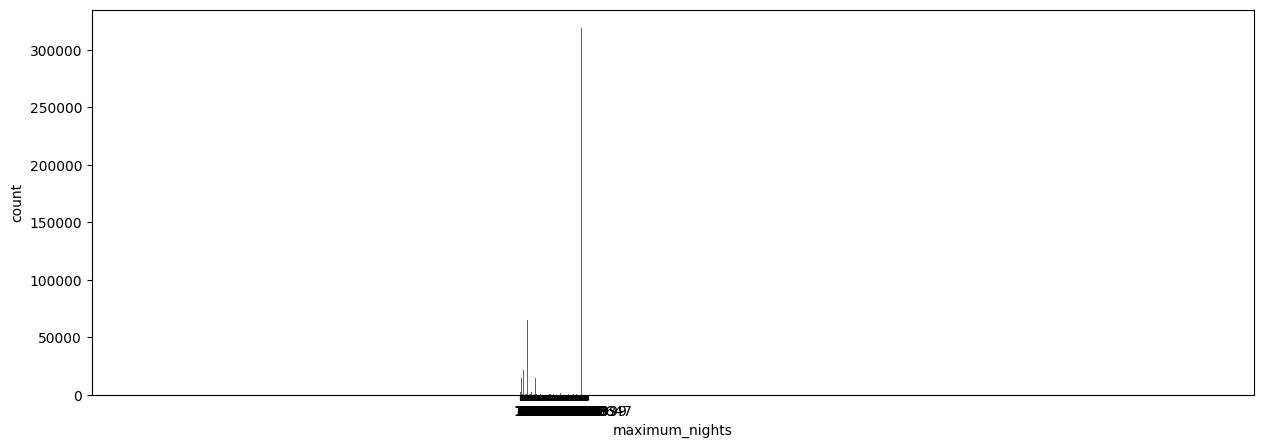

In [104]:
box_plot(base_airbnb['maximum_nights'])
bar_plot(base_airbnb['maximum_nights'])

In [105]:
# Removendo a coluna maximum_nights
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### 9. number_of_reviews
- Não me faz muito sentido retirar os outliers dos números de reviews em razão de donos de imóveis que estão há mais tempo na plataforma correrem o risco de serem retirados visto que há a possibilidade de possuirem um bom preço definido pela quantidade de reviews.
- Desta forma, é mais eficaz retirar a coluna, que possui um Box Plot não muito bem definido e muitos outliers interessantes para a análise.

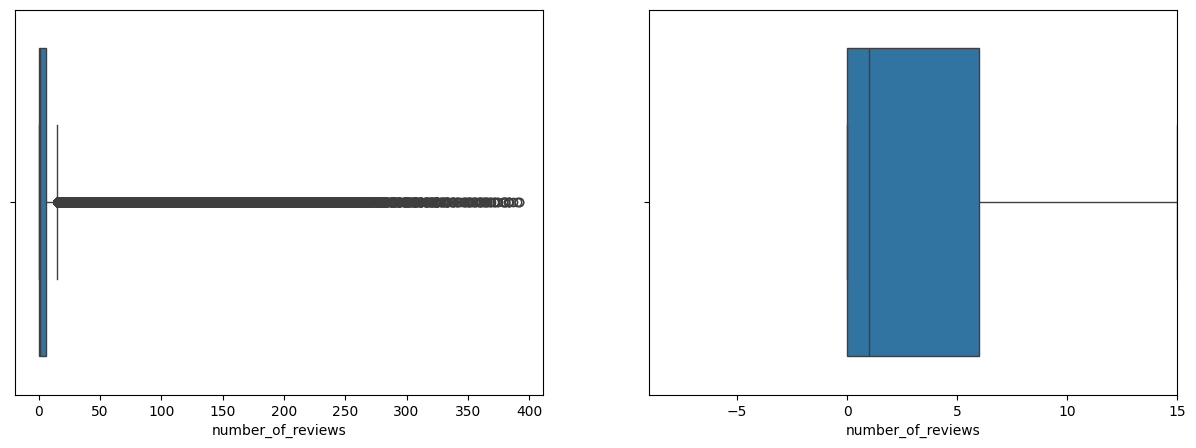

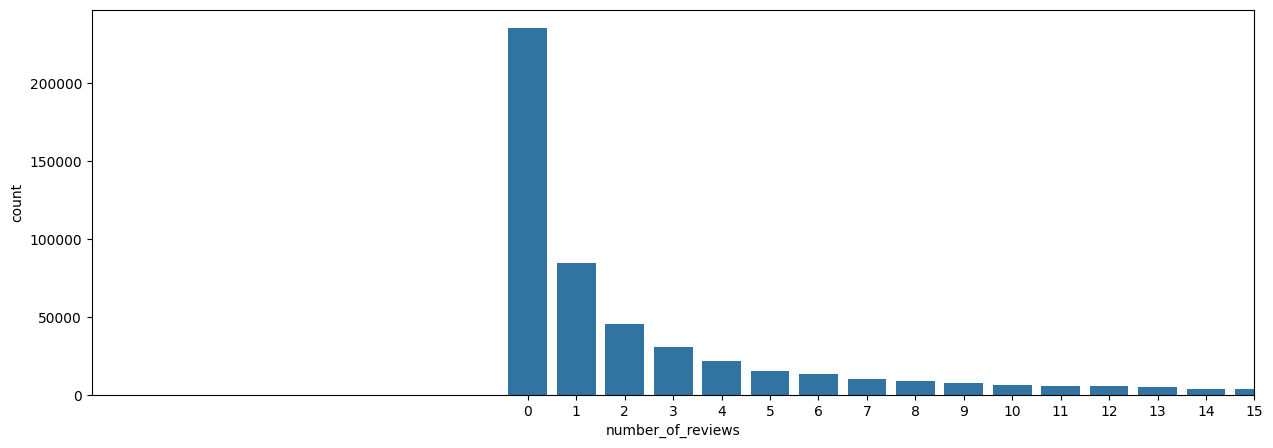

In [106]:
box_plot(base_airbnb['number_of_reviews'])
bar_plot(base_airbnb['number_of_reviews'])

In [107]:
# Removendo a coluna number_of_reviews
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratando Features de string e boolean
1. property_type
2. room_type
3. bed_type
4. cancellation_policy
5. amenities

### 1. property_type
- Analiso como os dados se distribuem e junto as categorias que estão em minoria de valores.

In [108]:
# visualizo como estão distribuidos
print(base_airbnb['property_type'].value_counts())

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

### Defino uma função para facilitar a visualização de dados categóricos

In [109]:
# crio um gráfico de barras que conta os dados categóricos
def count_plot(df, coluna):
    plt.figure(figsize=(15, 5))
    grafico = sns.countplot(x=df[coluna])
    grafico.tick_params(axis='x', rotation=90)

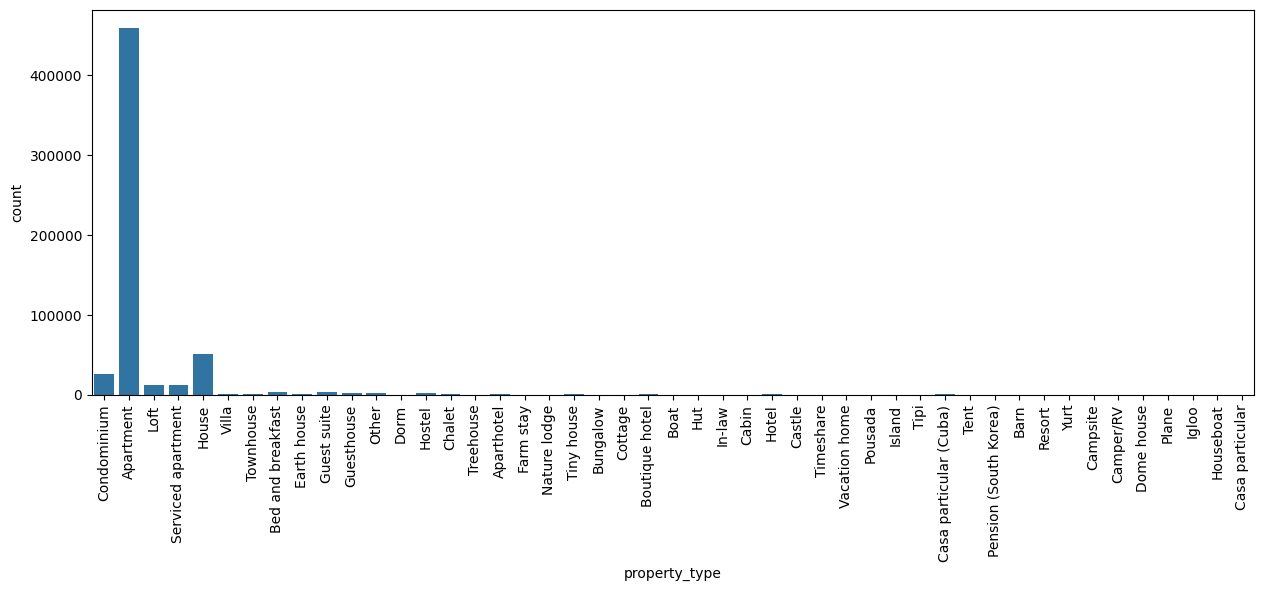

In [110]:
# Visualizo os dados categóricos em um count_plot
count_plot(base_airbnb, 'property_type')

property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Others                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


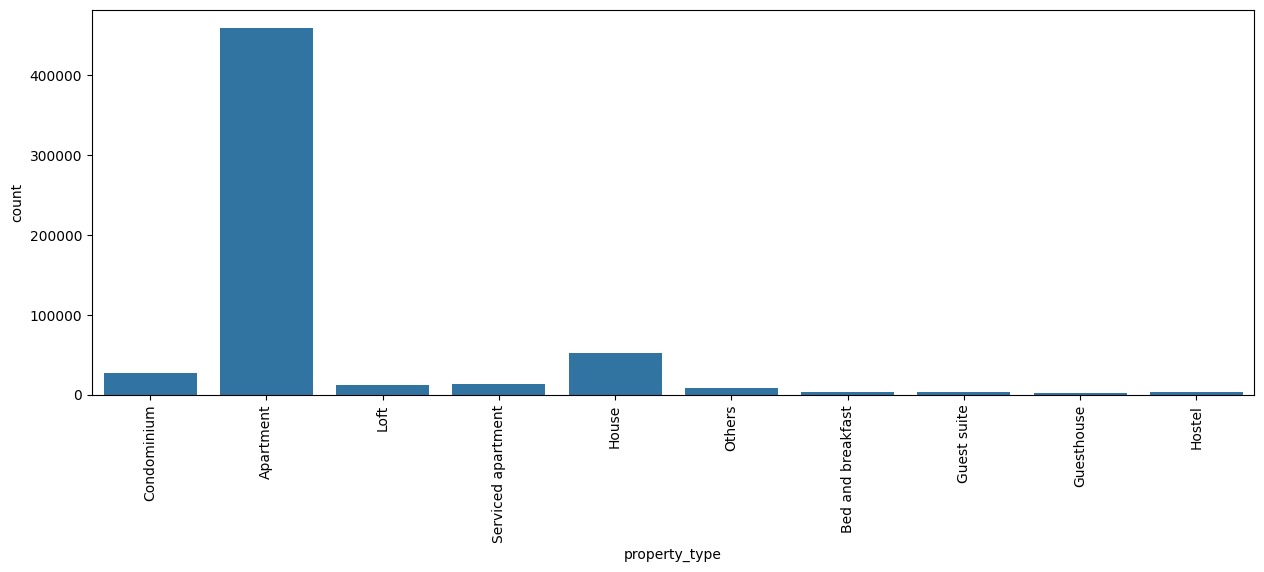

In [111]:
# itero pelos dados categóricos e agrupo os dados a partir do tipo "outros" (Other) que possuem menos de dois mil unidades no value_counts()
# atribuo o value_counts numa variável
tabela_tipos_casa = base_airbnb['property_type'].value_counts()

# defino a lista auxiliar
colunas_agrupar = []

# obtenho o index e atribuo os tipos de dados desejados na lista auxiliar
for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
       colunas_agrupar.append(tipo)

# filtro a feature original para exibir somente os dados categóricos que precisamos
# iterando sob o filtro
for tipo in colunas_agrupar:
    # localizo nas linhas tipo e coluna property_type
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Others'
    
# Verifico meus dados categóricos após o filtro
print(base_airbnb['property_type'].value_counts())

# Verifico os dados categóricos de property_type filtrados
count_plot(base_airbnb, 'property_type')

### 2. room_type
- Analiso como os dados se distribuem e a conclusão é que a quantidade de categorias está alinhado com o objetivo da análise.

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


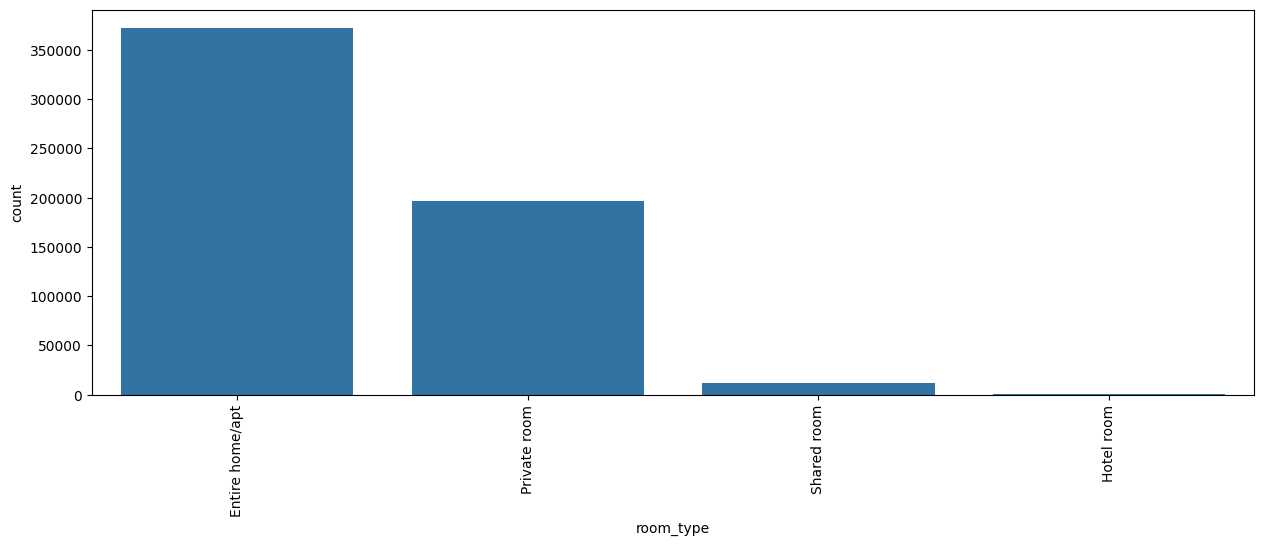

In [112]:
print(base_airbnb['room_type'].value_counts())

count_plot(base_airbnb, 'room_type')

### 3. bed_type
- Analiso como os dados se distribuem e a conclusão é que a quantidade de categorias pode ser sumarizada.
- Tipos de cama serão agrupados em 'Real Bed' e 'Others Beds'

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


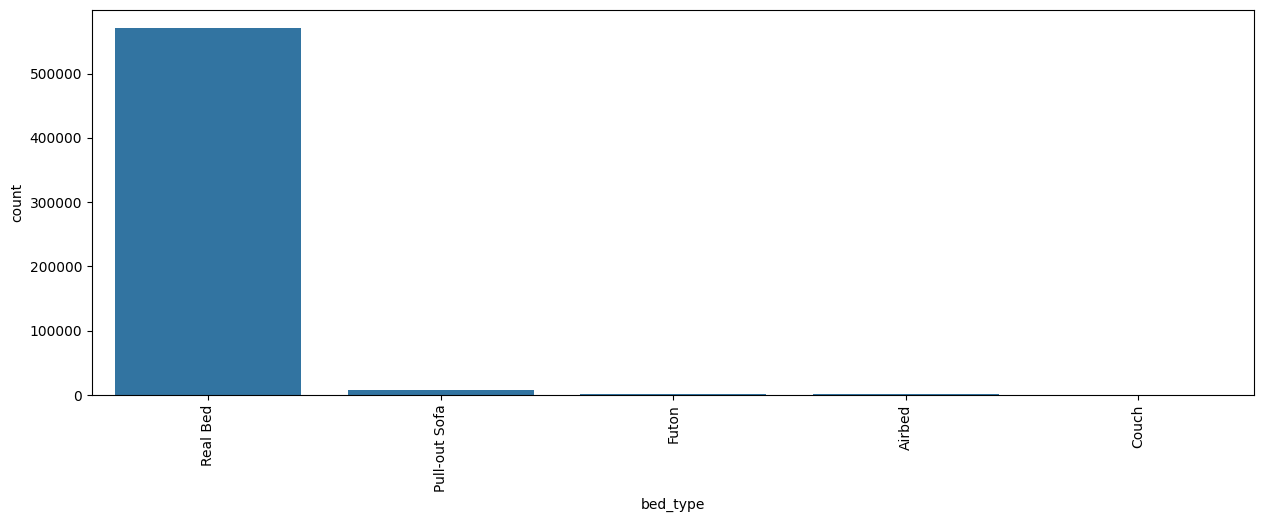

In [113]:
print(base_airbnb['bed_type'].value_counts())

count_plot(base_airbnb, 'bed_type')

bed_type
Real Bed    570643
Others       11340
Name: count, dtype: int64


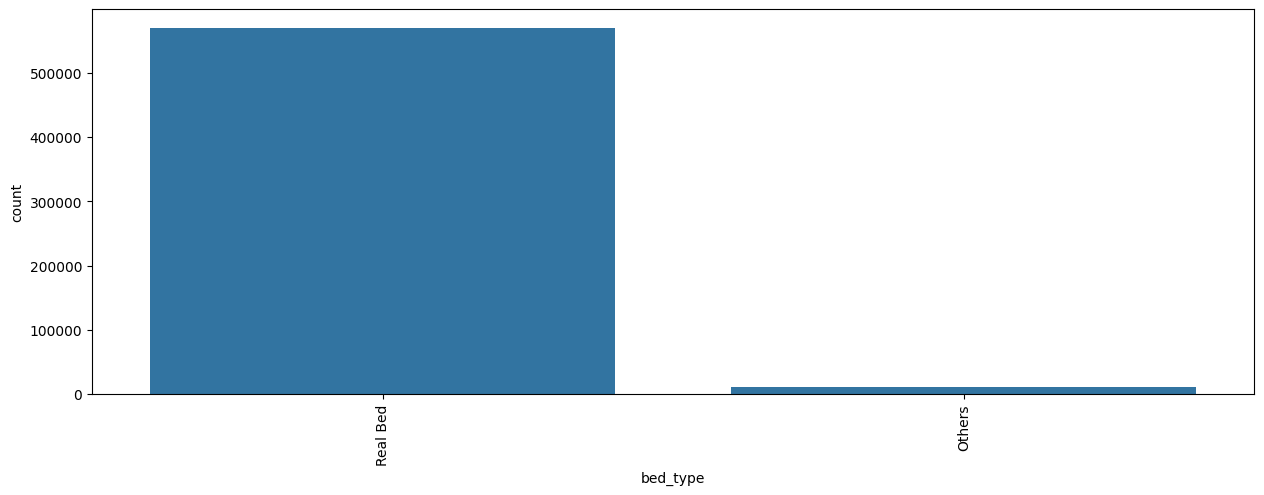

In [114]:
# itero pelos dados categóricos e agrupo os dados a partir do tipo "outros" (Other) que possuem menos de dois mil unidades no value_counts()
# atribuo o value_counts numa variável
tabela_tipos_cama = base_airbnb['bed_type'].value_counts()

# defino a lista auxiliar
colunas_agrupar = []

# obtenho o index e atribuo os tipos de dados desejados na lista auxiliar
for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] < 10000:
       colunas_agrupar.append(tipo)

# filtro a feature original para exibir somente os dados categóricos que precisamos
# iterando sob o filtro
for tipo in colunas_agrupar:
    # localizo nas linhas tipo e coluna bed_type
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Others'
    
# Verifico meus dados categóricos após o filtro
print(base_airbnb['bed_type'].value_counts())

# Verifico os dados categóricos de bed_type filtrados
count_plot(base_airbnb, 'bed_type')

### 4. cancellation_policy
- Analiso como os dados se distribuem e a conclusão é que a quantidade de categorias pode ser sumarizada.
- cancellation_policy do tipo restrito serão agrupados.

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


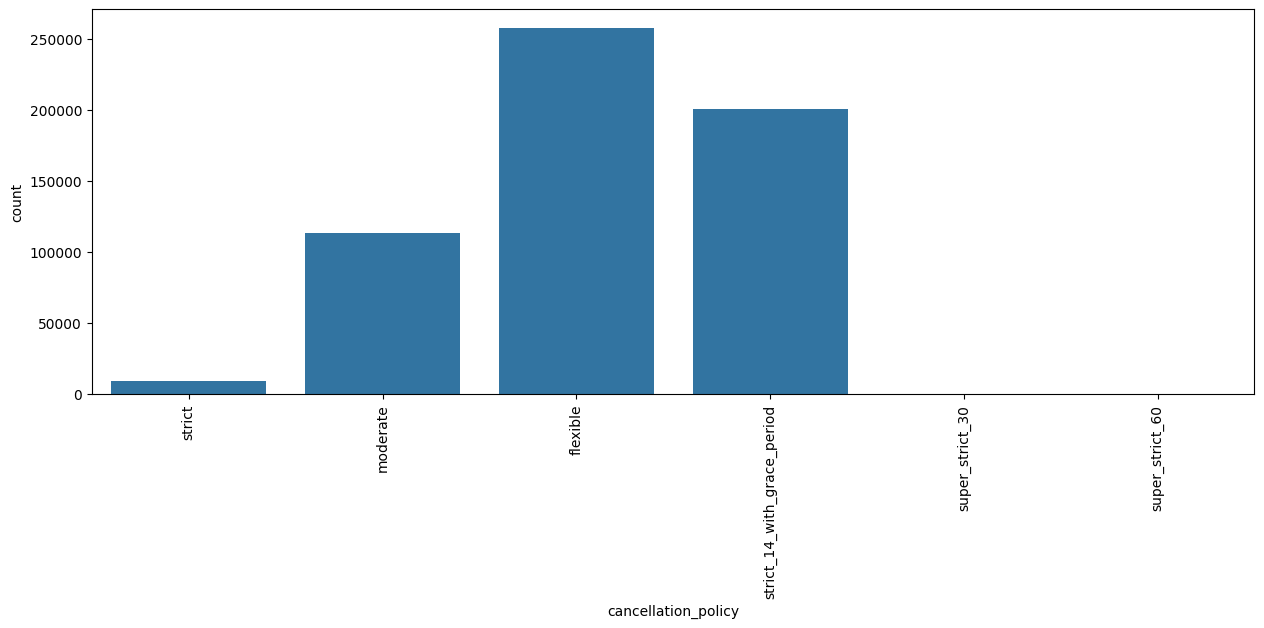

In [115]:
print(base_airbnb['cancellation_policy'].value_counts())

count_plot(base_airbnb, 'cancellation_policy')

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


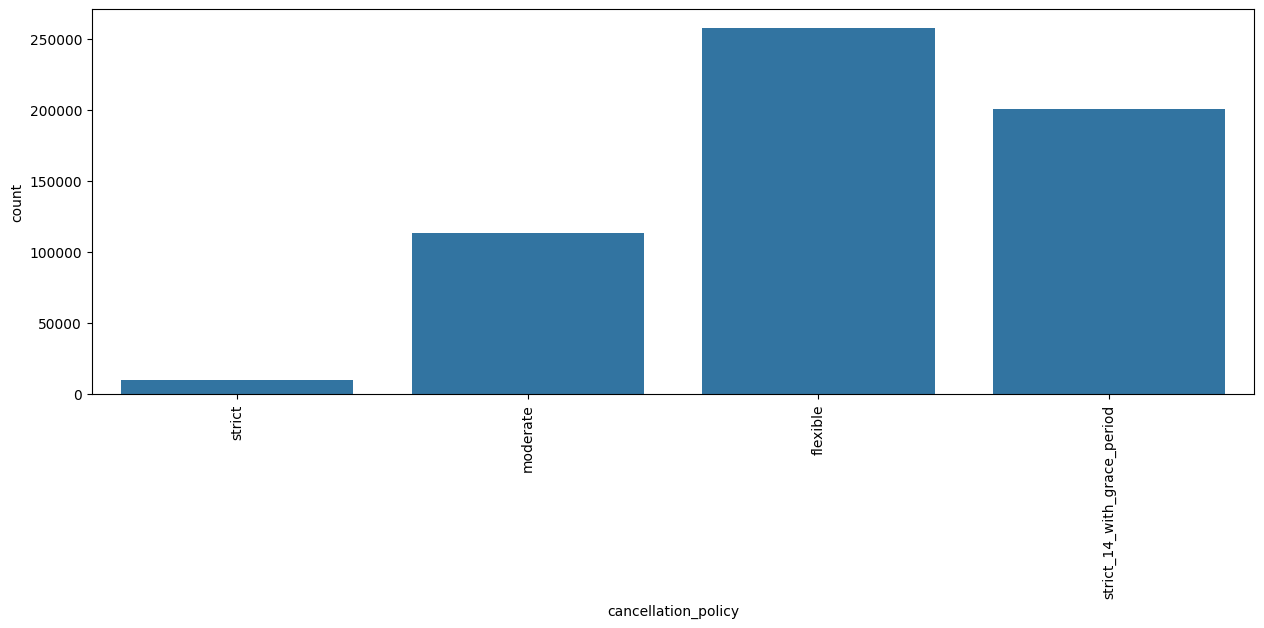

In [116]:
# itero pelos dados categóricos e agrupo os dados a partir do tipo "outros" (Other) que possuem menos de dois mil unidades no value_counts()
# atribuo o value_counts numa variável
tabela_tipos_cancellation = base_airbnb['cancellation_policy'].value_counts()

# defino a lista auxiliar
colunas_agrupar = []

# obtenho o index e atribuo os tipos de dados desejados na lista auxiliar
for tipo in tabela_tipos_cancellation.index:
    if tabela_tipos_cancellation[tipo] < 10000:
       colunas_agrupar.append(tipo)

# filtro a feature original para exibir somente os dados categóricos que precisamos
# iterando sob o filtro
for tipo in colunas_agrupar:
    # localizo nas linhas tipo e coluna cancellation_policy
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
    
# Verifico meus dados categóricos após o filtro
print(base_airbnb['cancellation_policy'].value_counts())

# Verifico os dados categóricos de cancellation_policy filtrados
count_plot(base_airbnb, 'cancellation_policy')

### 5. amenities
- Analiso como os dados se distribuem e a conclusão é que a quantidade de categorias está alinhado com o objetivo da análise.
- Por se tratar de uma feature com diversos valores dentro de cada linha, devo utilizar outra forma de tratamento.
- Os adendos que um local oferece será tratado da seguinte forma: "Qual a relação da quantidade de adendos com o preço do imóvel?".
- Desta forma, analiso a quantidade e não as categorias e/ou subcategorias de amenities.
- Serão sumarizados os valores em uma nova coluna, acrescido à base_airbnb e a feature 'amenities' (original) será deletada da base de dados.

In [117]:
# Verifico um exemplo de valor da feature e separo os amenities
print(base_airbnb['amenities'].iloc[0].split(','))

# Faço um teste de contagem da quantidade de amenities
print(len(base_airbnb['amenities'].iloc[0].split(',')))


['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [118]:
# crio a nova coluna com seus respectivos valores por imóvel e aplico no DataFrame
# uma função split em cada string da coluna e aplico a função len em cada um dos valores
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

# retiro a coluna amenities da base de dados
base_airbnb = base_airbnb.drop('amenities', axis=1)

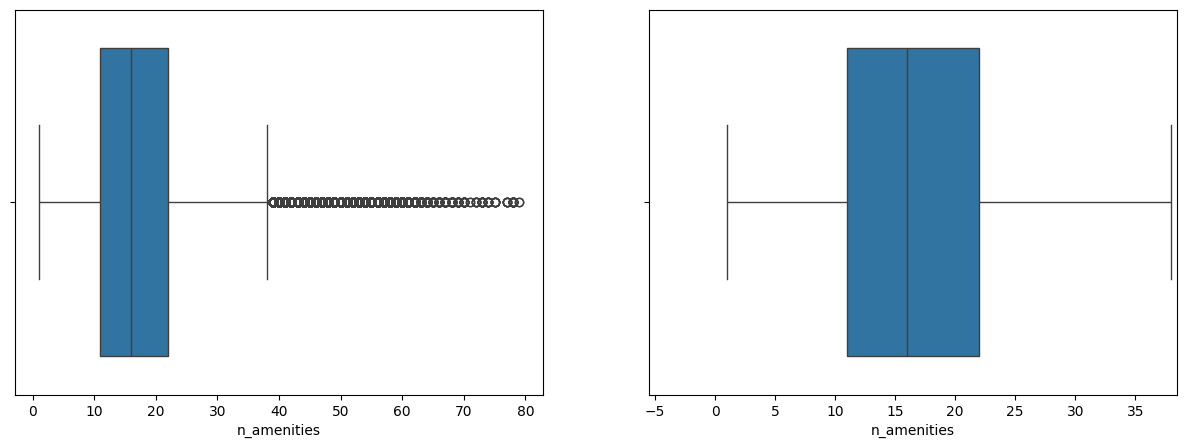

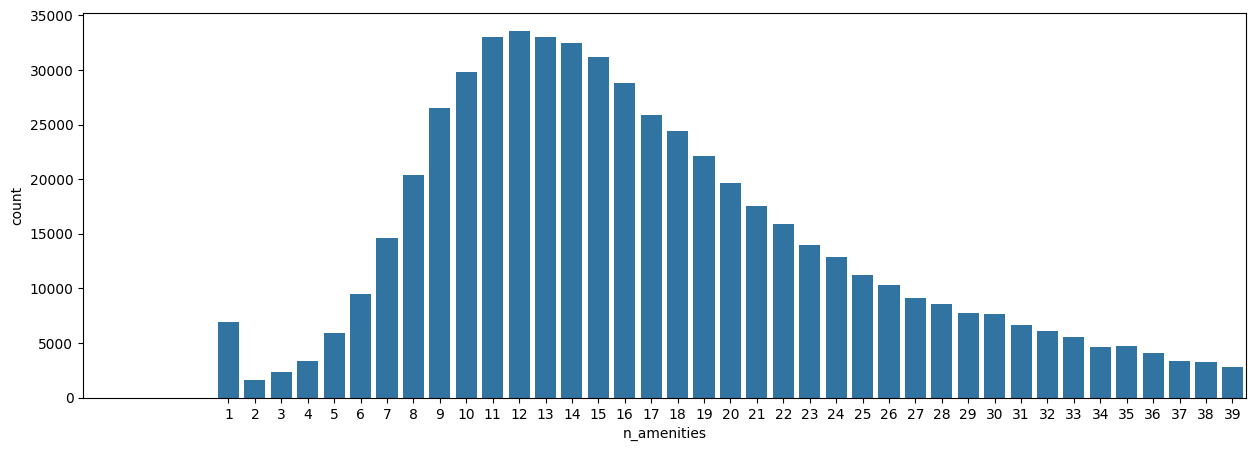

In [119]:
# Faço a análise de números discretos contínuos
box_plot(base_airbnb['n_amenities'])
bar_plot(base_airbnb['n_amenities'])

In [120]:
# Removendo outliers da coluna n_amenities em razão da maioria dos valores se encontrarem dentro do Box Plot.
base_airbnb, linhas_removidas = clear_outliers(base_airbnb, 'n_amenities')
print(linhas_removidas)

24343 linhas retiradas, aproximadamente: 4.18%


### Visualização de Mapa das Propriedades por preço em um Mapa de Calor


In [121]:
# O mapa será com base em uma amostra para facilitar a visualização e economizar consumo de memória.
amostra = base_airbnb.sample(n=50000)
# O parâmetro centro_mapa define a posição inicial da imagem
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

# Defino o mapa com a amostra, latitude, longitude, mapa de calor conforme coluna price
# radius é o tamanho dos pontos de calor, posição inicial do mapa, máximo zoom possível
# e estilo de mapa.
fig = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price',
                        radius=2.5, center=centro_mapa, zoom=10, mapbox_style='stamen-terrain')

fig.show()

### Encoding
- Transformando variáveis categóricas em numéricas para os modelos poderem analisar.
- Colunas Booleanas (True/False) serão numeradas em 0 para False e 1 para True.
- Colunas de texto com categorias serão aplicados conceitos de variáveis Dummies (OneHotEncoding).
  - Colunas de Texto Categóricas não devem ser enumeradas em razão do modelo correr o risco de associar uma hierarquia ou correlação de um valor ser maior/menor/dobro/metade comparado com outro.

In [122]:
# Tratamento de Colunas Booleanas
colunas_bool = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

# Não desejo alterar a base de dados original então faço uma cópia
base_airbnb_encoded = base_airbnb.copy()

# Itero e altero os valores
for coluna in colunas_bool:
    base_airbnb_encoded.loc[base_airbnb_encoded[coluna]=='t', coluna] = 1
    base_airbnb_encoded.loc[base_airbnb_encoded[coluna]=='f', coluna] = 0

In [123]:
# Tratamento de Colunas de Texto Categóricas
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

# O módulo Pandas possui o método get_dummies que transforma as colunas em variáveis dummies
# arg1: dataframe, arg2: quais colunas desejo alterar para variáveis dummies
base_airbnb_encoded = pd.get_dummies(data=base_airbnb_encoded, columns=colunas_categorias)

### Modelo de Previsão

Métricas de avaliação a serem utilizadas (biblioteca: SKLearn):
- R²
- RSME (Raíz do Erro Quadrático Médio)

In [130]:
# função que avalia o modelo utilizado comparando os valores corretos e reais (y_teste) comparado com a previsão (previsao) retornada
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo: {nome_modelo}\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

#### Escolha dos modelos a serem testados:
1. Regressão Linear;
2. Random Forest; e
3. Extra Trees.


In [125]:
# atribuo as funções dos modelos em variáveis
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

# para ficar mais intuitivo, incluo em um dict
modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et 
           }

# atribuo o dataset em x e y
y = base_airbnb_encoded['price'] # variável dependente
X = base_airbnb_encoded.drop('price', axis=1) # variáveis independentes

- Separo os dados em TREINO e TESTE do modelo.

In [126]:
# armazeno os valores para a função train_test_split da lib sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# itero sob o dict de modelos
for nome_modelo, modelo in modelos.items():
    # treino o modelo com os dados de treino
    modelo.fit(X_train, y_train)
    
    # testo o modelo treinado prevendo um valor real
    previsao = modelo.predict(X_test)
    
    # imprimo a previsão e comparo com valores reais (y_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo: RandomForest
R²:0.9724629396794734
RSME: 44.0040805397094
Modelo: LinearRegression
R²:0.3270168790140858
RSME: 217.53855974042654
Modelo: ExtraTrees
R²:0.9751435414652029
RSME: 41.807460573658226


### Análise do Melhor Modelo
- O Modelo de Regressão Linear possui um RSME muito alto, comparado com os outros dois não é interessante.
- O Modelo Extra Trees possui um RSME menor que o modelo Random Forest. Entre os dois, a velocidade de treino e previsão não foram muito diferentes, ressaltando a eficiência do Extra Trees neste caso. Concluo que este se sai melhor nos erros de valores específicos.

Resultados:
1. Modelo: RandomForest
- R²: 97.25%
- RSME: 44.00

2. Modelo: LinearRegression
- R²: 32.70%
- RSME: 217.54

3. Modelo: ExtraTrees
- R²: 97.51%
- RSME: 41.81

In [131]:
# formato as porcentagens e margens de erro e faço a exibição do teste novamente

# itero sob o dict de modelos
for nome_modelo, modelo in modelos.items():
    # testo o modelo treinado prevendo um valor real
    previsao = modelo.predict(X_test)
    
    # imprimo a previsão e comparo com valores reais (y_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo: RandomForest
R²: 97.25%
RSME: 44.00
Modelo: LinearRegression
R²: 32.70%
RSME: 217.54
Modelo: ExtraTrees
R²: 97.51%
RSME: 41.81


### Ajustes e Melhorias no Melhor Modelo

In [134]:
# porcentagem de "importância" de cada feature de acordo com o modelo Extra Trees Regressor
print(modelo_et.feature_importances_)

# Exibo as features
print(X_train.columns)


[0.0131445  0.03984291 0.10372587 0.10115102 0.07119726 0.06825539
 0.12563968 0.05272307 0.0862249  0.06495279 0.02213662 0.
 0.0112814  0.00470612 0.08930113 0.01284483 0.00129302 0.00520933
 0.00066198 0.00095027 0.00063097 0.00712132 0.00218073 0.00235687
 0.0022697  0.05757666 0.00030306 0.00480043 0.00182027 0.00270777
 0.00264105 0.01953619 0.01217306 0.00084808 0.00779177]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'ano',
       'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Others', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel r

In [137]:
# concateno as listas de features e respectivos valores em um DataFrame
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)

# ordeno o DataFrame
importancia_features = importancia_features.sort_values(by=0, ascending=False)

display(importancia_features)

0
bedrooms                                         0.125640
latitude                                         0.103726
longitude                                        0.101151
n_amenities                                      0.089301
extra_people                                     0.086225
accommodates                                     0.071197
bathrooms                                        0.068255
minimum_nights                                   0.064953
room_type_Entire home/apt                        0.057577
beds                                             0.052723
host_listings_count                              0.039843
instant_bookable                                 0.022137
cancellation_policy_flexible                     0.019536
host_is_superhost                                0.013144
property_type_Apartment                          0.012845
cancellation_policy_moderate                     0.012173
ano                                              0.011281
cancellation_policy_strict_14_with_grace_period  0.007792
property_type_House                              0.007121
property_type_Condominium                        0.005209
room_type_Private room                           0.004800
mes                                              0.004706
bed_type_Others                                  0.002708
bed_type_Real Bed                                0.002641
property_type_Others                             0.002357
property_type_Serviced apartment                 0.002270
property_type_Loft                               0.002181
room_type_Shared room                            0.001820
property_type_Bed and breakfast                  0.001293
property_type_Guesthouse                         0.000950
cancellation_policy_strict                       0.000848
property_type_Guest suite                        0.000662
property_type_Hostel                             0.000631
room_type_Hotel room                             0.000303
is_business_travel_ready                         0.000000

- As features no gráfico abaixo demonstram que existem muitas colunas abaixo de 2% de importância.

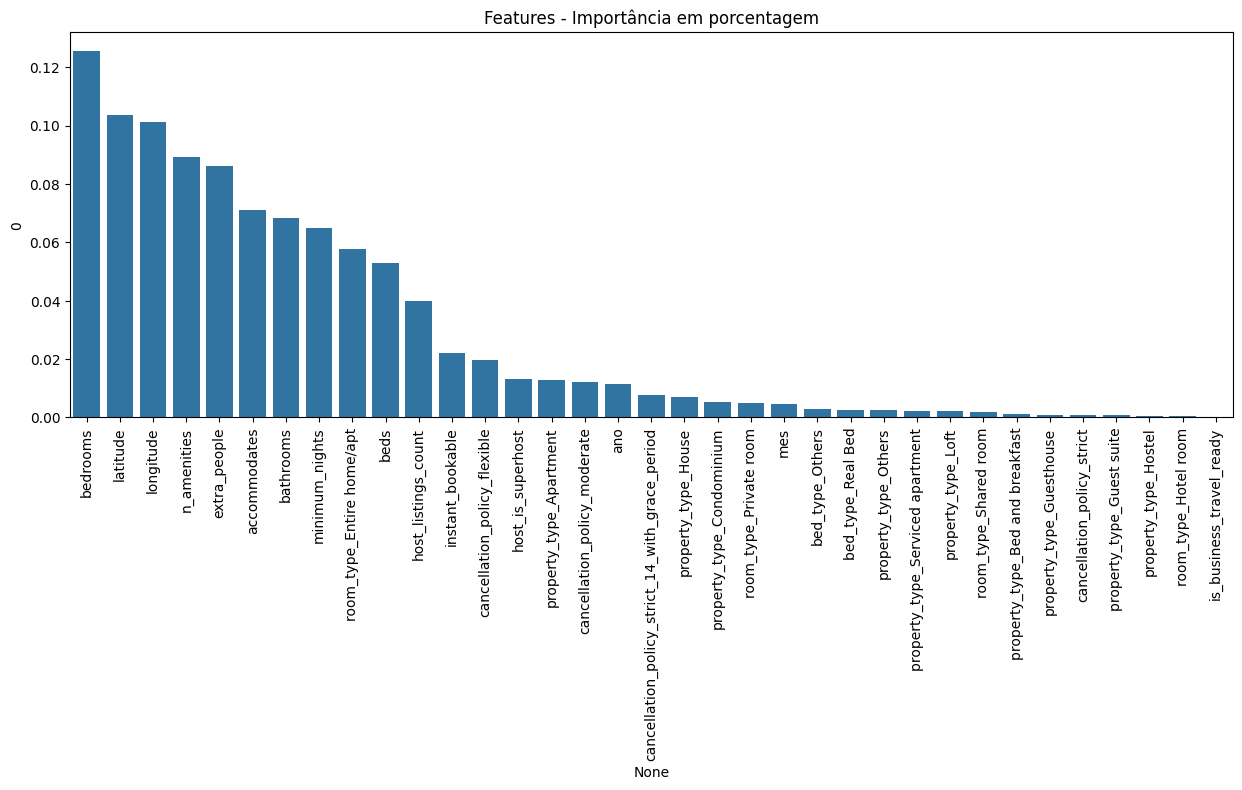

In [142]:
# Exibo as features e valores em um gráfico para analisar
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)
ax.set_title('Features - Importância em porcentagem');

### Deploy do Projeto

In [189]:
# exporto as informações em csv
X['price'] = y
X.to_csv('dados_ExtraTrees_Airbnb_RJ.csv')

In [190]:
# exporto o modelo em .joblib
import joblib
joblib.dump(modelo_et, 'ExtraTrees_Airbnb_RJ.joblib')

['ExtraTrees_Airbnb_RJ.joblib']

### [A ser finalizado] Excluiremos colunas com o objetivo de deixar o tempo de execução do modelo, menor.
- Poderia mesclar diversas colunas, mas opto por retirá-las ao invés disso por se tratarem de colunas com pouco impacto na precisão do modelo.

In [188]:
# Retiro as colunas com pouca importância de uma cópia do dataset
base_teste = base_airbnb_encoded.copy()

print(len(base_teste.columns))

# filtro a feature original para exibir somente os dados categóricos que precisamos
base_teste = base_teste.drop('is_business_travel_ready', axis=1)
base_teste = base_teste.drop('property_type_Guesthouse', axis=1)
base_teste = base_teste.drop('cancellation_policy_strict', axis=1)
base_teste = base_teste.drop('property_type_Guest suite', axis=1)
base_teste = base_teste.drop('property_type_Hostel', axis=1)

print(len(base_teste.columns))

36
31


In [ ]:
# atribuo a cópia do dataset encoded retirando colunas em x e y
y = base_teste['price']
x = base_teste.drop('price', axis=1)

# armazeno os valores para a função train_test_split da lib sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# itero sob o dict de modelos
for nome_modelo, modelo in modelos.items():
    # treino o modelo Extra Trees com os dados de treino
    modelo_et.fit(X_train, y_train)
    
    # testo o modelo treinado prevendo um valor real
    previsao = modelo.predict(X_test)
    
    # imprimo a previsão e comparo com valores reais (y_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))